In [1]:
import numpy as np
from astropy.table import Table, vstack

from matplotlib import pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('BrBG')
div_cmap = truncate_colormap(cmap, 0.2,0.8)
up_cmap = truncate_colormap(cmap, 0.5,1.0)

In [2]:
# load transfer function and tomographic bins
xfer_fn = np.load('../outputs/p_z_chat/BFD_xfer.npy')
redshifts = np.load('../outputs/p_z_chat/redshifts.npy')

# stack the accepted and trash bins
binned_accepted = Table.read('../outputs/binned_data/accepted_full.fits')
binned_rejected = Table.read('../outputs/binned_data/rejected.fits')
xx_bins = np.zeros(len(binned_rejected)) ; xx_bins.fill(-1)
binned_rejected['z bin 4'] = xx_bins
binned_rejected['z bin 5'] = xx_bins

binned_simulations = vstack([binned_accepted, binned_rejected])

deepres = 64
wideres = 32
ncells_deep = deepres*deepres
ncells_wide = wideres*wideres
numbins = 4

In [3]:
len(binned_accepted['z bin 4'])

8187319

# Correcting for Selection Effects

This notebook focuses on correcting for the effect of wide simulation noise on the galaxy's deep cell position. In our analysis, we assumed that given one deep field galaxy, each wide cell realization would still map to the same deep cell. This is not always the case, and so here we correct for that assumption.

To Illustrate this concept, we can take a look at how the average redshifts of all of the bins together compare to the average redshifts of the single bins. We will plot this next to the occupation of the cells. We expect that in the area where the occupation is highest, the total average minus the bin average is small, while at the edges of the bin occupation it should be furthest from zero. This is because at the edges of the bin occupations, bin overlap is higher.

In [4]:
# p(c|bhat)
p_c_bhat = {}
for bindex in range(-1,numbins):
    mask = (binned_simulations['z bin %i'%numbins]==bindex)
    t = binned_simulations[mask]
    pcb = np.histogram(t['DC'], ncells_deep, range=(0,ncells_deep))[0].astype(float)
    pcb[pcb==0] = np.nan
    p_c_bhat[str(bindex)] = pcb

In [5]:
grouped_by_deep_cell = binned_simulations.group_by('DC')
cell_averages = grouped_by_deep_cell.groups.aggregate(np.nanmean)

In [6]:
# <z_tot> - <z_bin>
spread = {}
for bindex in range(-1,numbins):
    mask = (binned_simulations['z bin %i'%numbins]==bindex)
    t = binned_simulations[mask]
    
    grouped_by_binned_deep_cell = t.group_by('DC')
    binned_cell_averages = grouped_by_binned_deep_cell.groups.aggregate(np.nanmean)
    binned_cell_averages.sort('DC')
    
    sp = []
    for i in range(ncells_deep):
        try:
            z = cell_averages[cell_averages['DC']==float(i)]['Z'][0]
            zb = binned_cell_averages[binned_cell_averages['DC']==float(i)]['Z'][0]
            sp += [z-zb]
        except IndexError:
            sp += [np.nan]
    
    spread[str(bindex)] = np.array(sp)

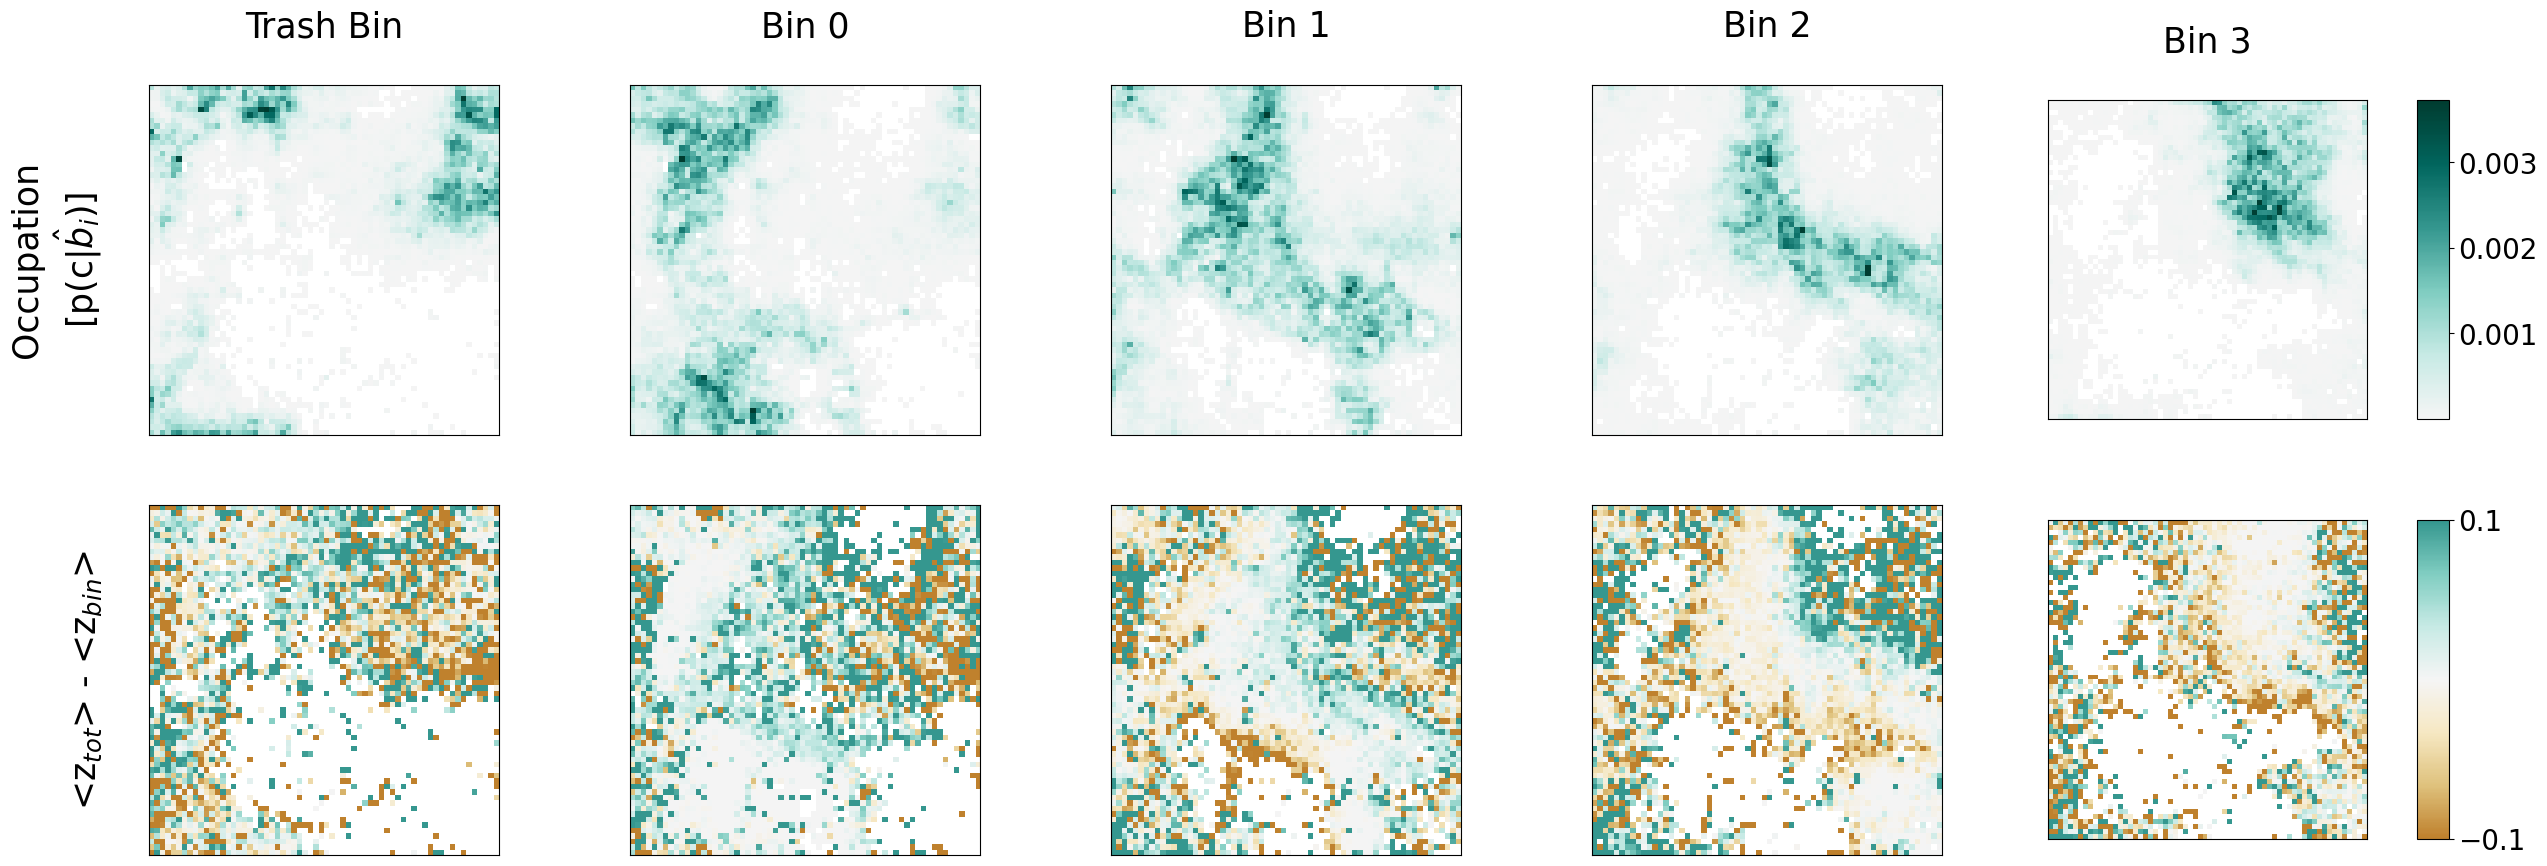

In [7]:
fig, axs = plt.subplots(2,numbins+1, figsize=(30,10))
for a,bindex in zip(axs.T,range(-1,numbins)):
    im0=a[0].imshow(p_c_bhat[str(bindex)].reshape(deepres, deepres)/np.nansum(p_c_bhat[str(bindex)]), cmap=up_cmap)
    im1=a[1].imshow(np.array(spread[str(bindex)]).reshape(deepres, deepres), vmin=-0.1, vmax=0.1, cmap=div_cmap)
    
    [ai.set_xticks([]) for ai in a]
    [ai.set_yticks([]) for ai in a]
    if bindex==-1:
        a[0].set_title('Trash Bin\n', fontsize=25) 
    else:
        a[0].set_title('Bin %i\n'%bindex, fontsize=25) 
        
divider = make_axes_locatable(a[1])
cax = divider.append_axes('right', size='10%', pad=0.5)
fig.colorbar(im1, cax=cax, orientation='vertical', ticks=[-0.1,0.1])
cax.tick_params(labelsize=20)

divider = make_axes_locatable(a[0])
cax = divider.append_axes('right', size='10%', pad=0.5)
fig.colorbar(im0, cax=cax, orientation='vertical')
cax.tick_params(labelsize=20)
    
    
axs[0,0].set_ylabel('Occupation\n'+r'[p(c|$\hat{b}_i$)]'+'\n', fontsize=25)
axs[1,0].set_ylabel(r'<z$_{tot}$> - <z$_{bin}$>'+'\n', fontsize=25)
plt.show()

# Getting the Probablility Function

Now we need to mathematically accountn for this selection effect in the final $p(z|\hat{b})$. The end result of this process should be a redshift distribution given a tomographic bin:


\begin{align}
p(z|\hat{b}) & = \sum_{\hat{c}\epsilon \hat{b}} p(z|c, \hat{b}) * p(\hat{c}|\hat{s}, \hat{b}) \\
             & = \sum_{\hat{c}\epsilon \hat{b}} \sum_{c} p(z|c,\hat{c}) * p(c|\hat{c}) * p(\hat{c}|\hat{b}) \\
\end{align}

Where:
- $p(z|c,\hat{c})$ is what we need to find
- $p(c|\hat{c})$ is the transfer function (already found)
- $p(\hat{c}|\hat{b})$ is 0 or 1, denoting whether $\hat{c}$ is in the bin $\hat{b}$ or not


$p(z|c,\hat{c})$ is, in theory, a redshift distribution between each wide cell $c$ and deep cell $\hat{c}$. This would mean 22 x 22 x 48 x 48 redshift distributions, which would require a(n impossibly) large number of wide realizations. Instead, we approximate:
$$
p(z|c,\hat{c}) \approx p(z|c,\hat{b})
$$

which requires a redshift distribution between each deep cell $c$ and each bin $\hat{b}$ (nbins x (64x64) distributions). 


$p(z|c,\hat{b}_i)$ is very similar to the calculation of $p(z|c)$ but it's done with the data split into each tomographic bin.

In [8]:
max_redshift=4
num_zbins = 150 ; zrange = (0,max_redshift)

pzcbs = {}
pzcbs_unnormed = {}
cz = [np.array([])]*ncells_deep 
for bindex in range(-1,numbins):
    mask = (binned_simulations['z bin %i'%numbins]==bindex)
    t = binned_simulations[mask]
    for row in t:
        cz[int(row['DC'])] = np.append(cz[int(row['DC'])], [row['Z']])
    
    pzcb_unnormed = np.zeros((num_zbins, ncells_deep)) 
    pzcb = np.zeros((num_zbins, ncells_deep)) 
    for i in range(ncells_deep):
        pzcb[:,i] = np.histogram(cz[i], num_zbins, range=zrange)[0]/len(cz[i])
        pzcb_unnormed[:,i] = np.histogram(cz[i], num_zbins, range=zrange)[0]

    pzcb = np.nan_to_num(pzcb)
    
    pzcbs[str(bindex)] = pzcb
    pzcbs_unnormed[str(bindex)] = pzcb_unnormed
    
    print(np.nansum(pzcb), pzcb.shape) # << should sum to the number of *occupied* deep cells (<= 4096)

/var/folders/nt/7hp8jjq563b09vy01vqx17dh0000gn/T/ipykernel_31513/2160464586.py:16: RuntimeWarning: invalid value encountered in true_divide
  pzcb[:,i] = np.histogram(cz[i], num_zbins, range=zrange)[0]/len(cz[i])


2566.056448733144 (150, 4096)
3498.06402722642 (150, 4096)
3956.692348474459 (150, 4096)
4008.4303341789564 (150, 4096)
4024.35299358146 (150, 4096)


Now we can calculate 
$$
\sum_c p(z|c, \hat{b}) * p(c|\hat{c})
$$

for each bin

In [9]:
p_z_c_bhat = {key: np.einsum('ab,bc->ac', pzcbs[key], xfer_fn) for key in pzcbs}

And finally, 
$$
p(z|\hat{b}) = \sum_{\hat{c}\epsilon \hat{b}} p(z|c, \hat{b}) * p(\hat{c}|\hat{s}, \hat{b})
$$

In [10]:
masks = {str(bindex): (binned_simulations['z bin %i'%numbins]==bindex) for bindex in range(-1,numbins)}
p_c_b = {key: [1 if c in binned_simulations['WC'][masks[key]] else 0 for c in range(ncells_wide)] 
         for key in p_z_c_bhat}

In [11]:
p_z_bhat = {key: np.einsum('ab,b->a', p_z_c_bhat[key], p_c_b[key]) for key in p_c_b}
p_z_bhat = {key: p_z_bhat[key]/np.sum(p_z_bhat[key]) for key in p_c_b}

# Plots

In [12]:
from scipy.ndimage import gaussian_filter1d

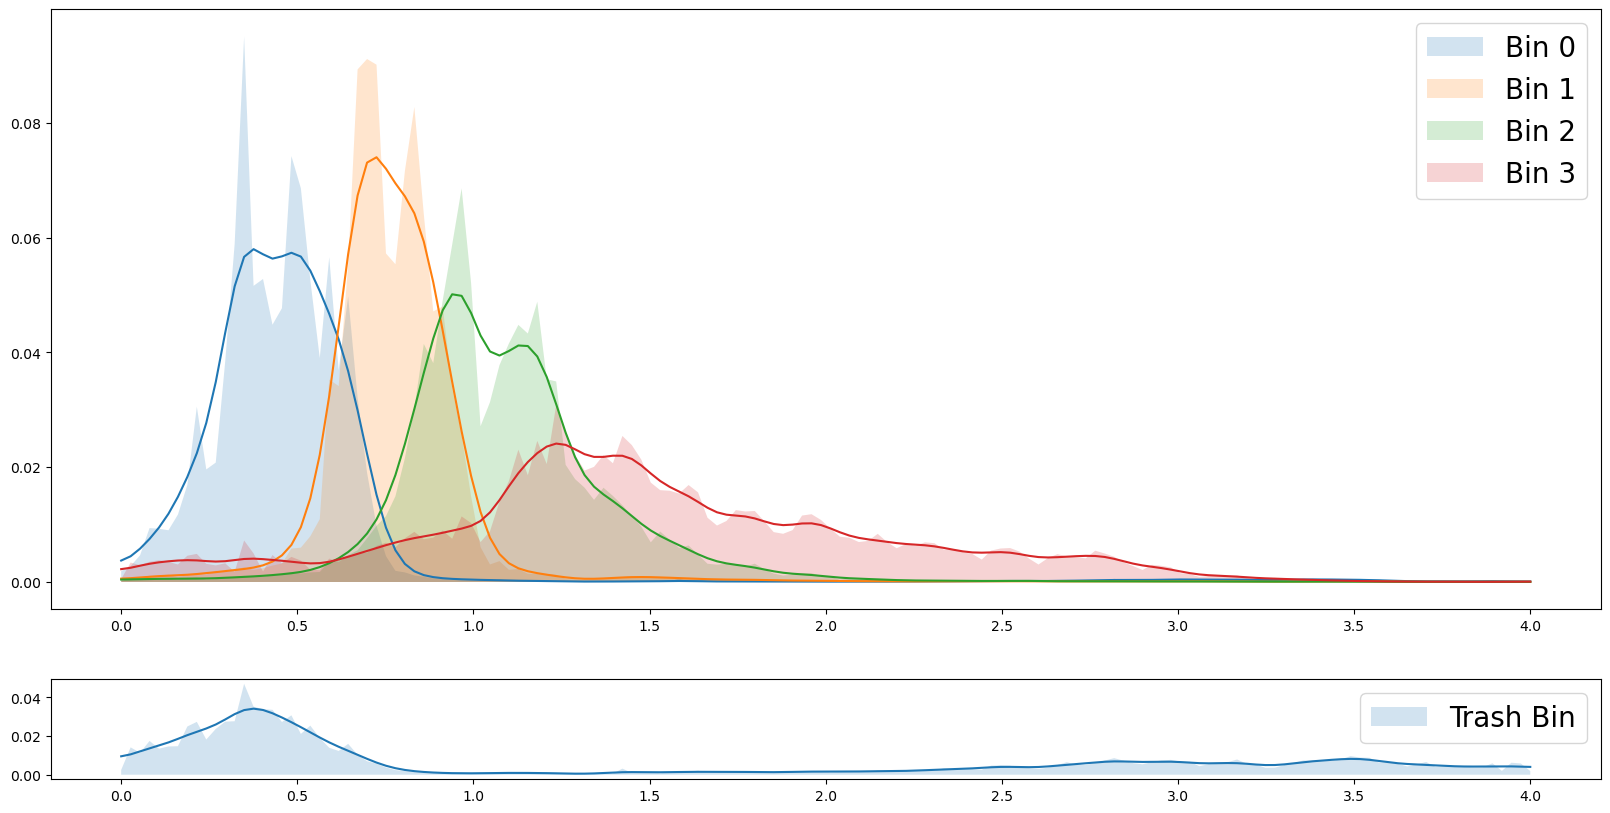

In [13]:
fig, ax = plt.subplots(2,figsize=(20,10), height_ratios=[6,1])

for key in p_z_bhat:
    if key == '-1': continue
    ax[0].plot(redshifts, gaussian_filter1d(p_z_bhat[key], 2))
    ax[0].fill_between(redshifts, p_z_bhat[key], alpha=0.2, label='Bin %s'%key)
    
ax[1].plot(redshifts, gaussian_filter1d(p_z_bhat['-1'], 2))  
ax[1].fill_between(redshifts, p_z_bhat['-1'], alpha=0.2, label='Trash Bin')

ax[1].legend(fontsize=20)
ax[0].legend(fontsize=20)
plt.show()